In [39]:
import re
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd

In [13]:
def parse_line(line_str):
    bit_str = line_str.split()[3]
    bit_options = [("MiB", 1000000), ("KiB", 1000), ("B", 1)]
    for (bit_option, mult) in bit_options:
        if bit_option in bit_str:
            split = bit_str.split(bit_option)
            return float(split[0]) * mult
    return 0

In [14]:
def pull_ss_data(line_str):
    cwnd = re.findall(r'\d+', line_str.split("cwnd:")[1])[0]
    print(cwnd)

In [56]:
def get_scale(s, offset):
    if s == "full":
        return [0,-1]
    else:
        return [offset, int(offset + (s * 100))]

In [174]:
conditions = ["cubic_delay", "cubic_loss_005", "cubic_loss_01", "bbr_delay", "bbr_loss_005", "bbr_loss_01"]
through_pat = "enX0.+"
ss_header_pat = "State Recv-Q.+\n.+\n"
cwnd_pat = " cwnd:\d+"
ssthresh_pat = " ssthresh:\d+"
rtt_pat = " rtt:\d+"
through_vals = []
cwnd_vals = [[] for _ in range(len(conditions))]
ssthresh_vals = [[] for _ in range(len(conditions))]
rtt_vals = [[] for _ in range(len(conditions))]
rate_interval = .01
times = []
for i in range(len(conditions)):
    with open(f"data/{conditions[i]}_bmon_out.txt", 'r') as f:
        matches = re.findall(through_pat, f.read())
        cond_through_vals = [float(parse_line(match)) for match in matches]
    through_vals.append(cond_through_vals)
    
    with open(f"data/{conditions[i]}_ss_out.txt", 'r') as f:
        text = f.read()
        for entry in re.findall(ss_header_pat, text):
            cwnd_match = re.findall(cwnd_pat, entry)
            if cwnd_match:
                cwnd_val = int(cwnd_match[0].split(":")[1])
            else:
                cwnd_val = 0
            cwnd_vals[i].append(cwnd_val)
            
            ssthresh_match = re.findall(ssthresh_pat, entry)
            if ssthresh_match:
                ssthresh_val = int(ssthresh_match[0].split(":")[1])
            else:
                ssthresh_val = np.nan
            ssthresh_vals[i].append(ssthresh_val)

            rtt_match = re.findall(rtt_pat, entry)
            if rtt_match:
                rtt_val = int(rtt_match[0].split(":")[1])
            else:
                rtt_val = np.nan
            rtt_vals[i].append(rtt_val)


In [276]:
cur_cond = 2
cur_scale = 1
offset = 70
val_obj = cwnd_vals

[l,r] = get_scale(cur_scale, offset)

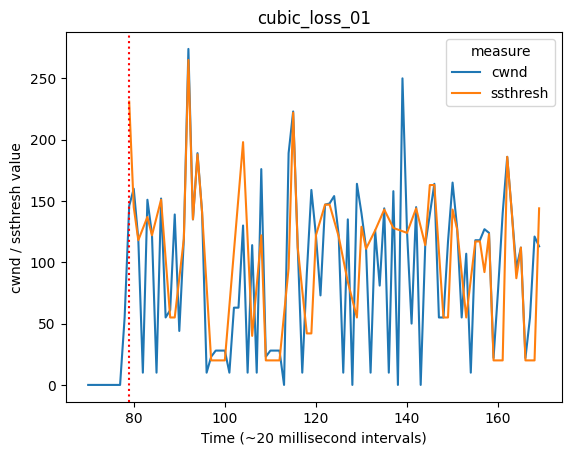

In [281]:
# Generate cwnd/ssthresh graph
num_sam = len(cwnd_vals[cur_cond][l:r])
data = pd.DataFrame({'time': (list(range(offset, offset+num_sam)))*2, 'val': cwnd_vals[cur_cond][l:r] + ssthresh_vals[cur_cond][l:r], 'measure': (["cwnd"]*num_sam) + (["ssthresh"]*num_sam)})
sns.lineplot(data, x="time", y="val", hue="measure")
plt.xlabel("Time (~20 millisecond intervals)")
plt.ylabel("cwnd / ssthresh value")
plt.title(conditions[cur_cond])
#plt.axvline(79, color='red', linestyle=":")

Text(0.5, 1.0, 'cubic_loss_01 vs. bbr_loss_01')

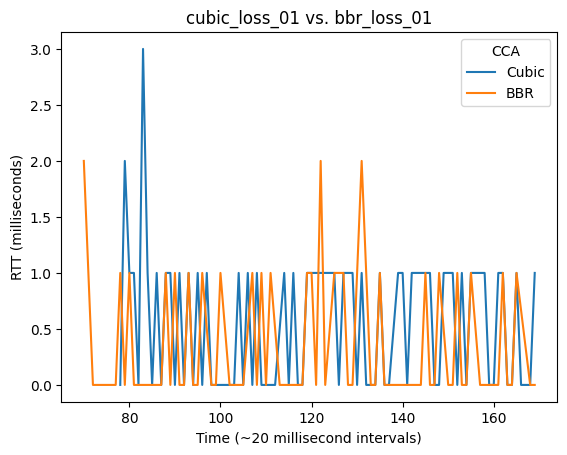

In [282]:
# Generate rtt graph, cubic vs bbr
# Condition must be in [0,1,2] for this
num_sam = len(rtt_vals[cur_cond][l:r])
data = pd.DataFrame({'time': (list(range(offset, offset+num_sam)))*2, 'val': rtt_vals[cur_cond][l:r] + rtt_vals[cur_cond+3][l:r], 'CCA': (["Cubic"]*num_sam) + (["BBR"]*num_sam)})
sns.lineplot(data, x="time", y="val", hue="CCA")
plt.xlabel("Time (~20 millisecond intervals)")
plt.ylabel("RTT (milliseconds)")
plt.title(f"{conditions[cur_cond]} vs. {conditions[cur_cond+3]}")

Text(0.5, 1.0, 'cubic_loss_01 vs. bbr_loss_01')

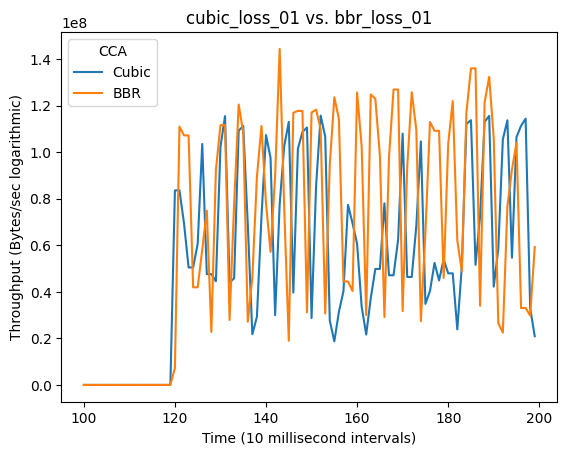

In [261]:
# Generate throughput graph, cubic vs. bbr
# Condition must be in [0,1,2] for this
cubic_onset = [v > 100000 for v in through_vals[cur_cond]].index(True) - 20
bbr_onset = [v > 100000 for v in through_vals[cur_cond+3]].index(True) - 20
num_sam = len(through_vals[cur_cond][l:r])
data = pd.DataFrame({'time': (list(range(offset, offset+num_sam)))*2, 'val': through_vals[cur_cond][cubic_onset:cubic_onset+r-l] + through_vals[cur_cond+3][bbr_onset:bbr_onset+r-l], 'CCA': (["Cubic"]*num_sam) + (["BBR"]*num_sam)})
sns.lineplot(data, x="time", y="val", hue="CCA")
plt.xlabel("Time (10 millisecond intervals)")
plt.ylabel("Throughput (Bytes/sec logarithmic)")
plt.title(f"{conditions[cur_cond]} vs. {conditions[cur_cond+3]}")